In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout, GaussianNoise, GlobalMaxPooling2D, Conv2DTranspose, DepthwiseConv2D, Add, Concatenate, LeakyReLU, MaxPool2D, SpatialDropout2D
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip, RandomRotation, Normalization, RandomWidth, RandomHeight, RandomCrop
from tensorflow.keras.regularizers import L2
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import itertools

plt.rcParams["figure.figsize"] = (6,6)

In [2]:
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Tue Mar 16 15:54:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   64C    P0    N/A /  N/A |    572MiB /  4040MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
train_ds = tfds.load('cifar10', split='train', shuffle_files=True, as_supervised=True).map(lambda x, y: (tf.cast(x, dtype=tf.float32), y)).shuffle(1024).batch(512, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = tfds.load('cifar10', split='test', shuffle_files=True, as_supervised=True).map(lambda x, y: (tf.cast(x, dtype=tf.float32), y)).shuffle(1024).batch(1024, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

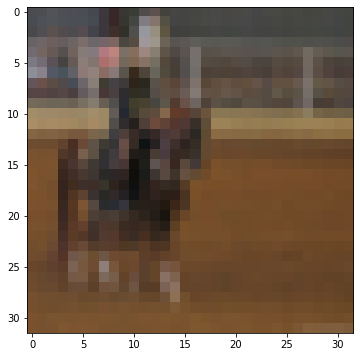

horse


In [4]:
batch, labels = iter(train_ds).next()

def show_img(img):
    npimg = img.numpy()
    plt.imshow(npimg/255)
    plt.show()

show_img(batch[0])
print(classes[labels[0].numpy()])

In [6]:
epochs = 400
warmup_epochs = 4
max_lr = 1e-1
min_lr = 5e-4

In [6]:
lr_c = (min_lr/max_lr)**(1/(epochs-warmup_epochs))

def lr_scheduler(epoch, lr):
    if epoch < warmup_epochs:
        nlr = max_lr/warmup_epochs*(epoch+1)
    else:
        nlr = lr * lr_c
    print("Learning Rate update to:", nlr)
    return nlr

lr_m = (min_lr-max_lr)/(epochs-warmup_epochs)
lr_b = max_lr-lr_m*warmup_epochs

def linear_lr_scheduler(epoch, lr):
    if epoch < warmup_epochs:
        nlr = max_lr/warmup_epochs*(epoch+1)
    else:
        nlr = lr_m*(epoch+1) + lr_b
    print("Learning Rate updated to:", nlr)
    return nlr

lr_callback = tf.keras.callbacks.LearningRateScheduler(linear_lr_scheduler)

In [7]:
l2 = 1.25e-4
noise = 0.15
batchnorm_subdivision_size = 64

model_input = Input(shape=(32,32,3))
parsed_input = Sequential([
    Normalization(mean=[125.3, 123.0, 113.9], variance=[63.0, 62.1, 66.7]),
    RandomFlip(mode='horizontal'),
    RandomWidth((0, 0.25)),
    RandomHeight((0, 0.25)),
    RandomCrop(32, 32),
    GaussianNoise(0.05)
])(model_input)

input_block1 = Sequential([
    RandomContrast(0.1),
    Conv2D(64, 5, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(64, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(128, 3, padding='same', kernel_regularizer=L2(l2=l2))
])(parsed_input)

input_block2 = Sequential([
    RandomRotation(0.15),
    Conv2D(64, 5, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(64, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(128, 3, padding='same', kernel_regularizer=L2(l2=l2))
])(parsed_input)

input_block = SpatialDropout2D(0.2)(Concatenate()([input_block1, input_block2]))

block1_out = Sequential([
    GaussianNoise(noise),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(128, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(256, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(256, 3, padding='same', kernel_regularizer=L2(l2=l2))
])(input_block)

block2_out = Sequential([
    MaxPool2D(),
    GaussianNoise(noise),
    SpatialDropout2D(0.2),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(256, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(256, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(256, 3, padding='same', kernel_regularizer=L2(l2=l2))
])(Add()([input_block, block1_out]))

block3_out = Sequential([
    GaussianNoise(noise),
    SpatialDropout2D(0.2),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(256, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(384, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(384, 3, padding='same', kernel_regularizer=L2(l2=l2))
])(Concatenate()([MaxPool2D()(block1_out), block2_out]))

block4_out = Sequential([
    MaxPool2D(),
    GaussianNoise(noise),
    SpatialDropout2D(0.2),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(384, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(384, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(384, 3, padding='same', kernel_regularizer=L2(l2=l2))
])(Concatenate()([block2_out, block3_out]))

block5_out = Sequential([
    GaussianNoise(noise),
    SpatialDropout2D(0.2),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(512, 3, padding='same', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(512, 3, padding='valid', kernel_regularizer=L2(l2=l2)),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Conv2D(512, 3, padding='valid', kernel_regularizer=L2(l2=l2))
])(Concatenate()([MaxPool2D()(block3_out), block4_out]))

dense_out = Sequential([
    MaxPool2D(),
    GaussianNoise(noise),
    Flatten(),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Dropout(0.4),
    Dense(256),
    LeakyReLU(),
    BatchNormalization(virtual_batch_size=batchnorm_subdivision_size),
    Dense(10)
])(block5_out)

model = Model(model_input, dense_out)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr)
optimizer = tf.keras.optimizers.SGD(learning_rate=max_lr, momentum=0.9)
#https://ruder.io/optimizing-gradient-descent/
# seems to be preferred in modern papers

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 32, 32, 3)    7           input_2[0][0]                    
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 32, 32, 128)  116160      sequential_9[0][0]               
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 32, 32, 128)  116160      sequential_9[0][0]               
____________________________________________________________________________________________

Epoch 1/400
Learning Rate updated to: 0.025
97/97 [==============================] - 103s 904ms/step - loss: 2.7385 - sparse_categorical_accuracy: 0.3095 - val_loss: 5.4088 - val_sparse_categorical_accuracy: 0.2490

Epoch 00001: val_loss improved from inf to 5.40880, saving model to cifar-10-res.h5
Epoch 2/400
Learning Rate updated to: 0.05
97/97 [==============================] - 82s 844ms/step - loss: 2.1972 - sparse_categorical_accuracy: 0.4631 - val_loss: 2.8219 - val_sparse_categorical_accuracy: 0.4240

Epoch 00002: val_loss improved from 5.40880 to 2.82193, saving model to cifar-10-res.h5
Epoch 3/400
Learning Rate updated to: 0.07500000000000001
97/97 [==============================] - 82s 845ms/step - loss: 1.9540 - sparse_categorical_accuracy: 0.5509 - val_loss: 3.2876 - val_sparse_categorical_accuracy: 0.4844

Epoch 00003: val_loss did not improve from 2.82193
Epoch 4/400
Learning Rate updated to: 0.1
97/97 [==============================] - 82s 850ms/step - loss: 1.7559 - spa

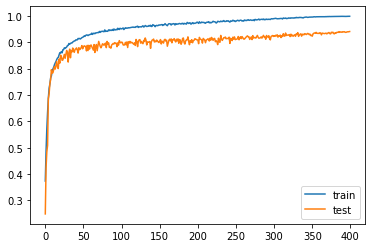

In [8]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('cifar-10-res.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(train_ds, epochs=epochs, validation_data=test_ds, callbacks=[lr_callback, checkpoint])

plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.show()

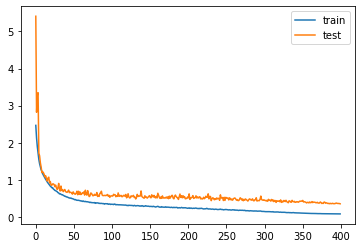

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
model.load_weights("cifar-10-res.h5")

In [9]:
def plot_confusion_matrix(cm, class_names):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

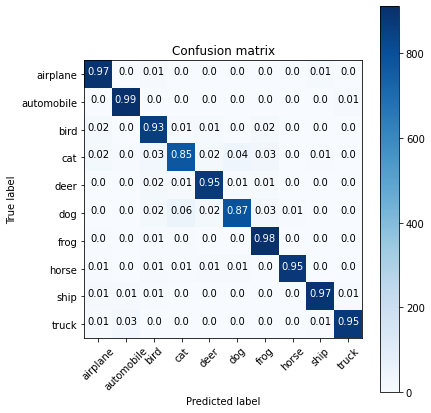

[[897   1   9   2   0   0   3   0  12   3]
 [  1 911   1   0   0   0   0   0   1   9]
 [ 15   0 864  10  12   3  17   1   3   0]
 [ 15   4  26 773  16  36  30   3   7   2]
 [  2   1  15   9 877   5  13   3   0   0]
 [  3   0  19  55  15 788  23   6   1   0]
 [  4   0   6   4   1   0 907   0   0   1]
 [  5   1   9   6   9   8   1 882   3   1]
 [  9  10   5   0   0   0   0   0 891   6]
 [  7  28   1   1   0   0   2   0   5 881]]


In [11]:
images = []
labels = []

for x in test_ds:
    images.append(x[0])
    labels.append(x[1])

images = tf.concat(images, axis=0)
y_pred = model.predict(images, batch_size=128)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(labels, axis=0)

cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, classes)
print(cm)

Res V2: 85.07%

Res V3s: 0.67547, 84.18%

Res V4s: 0.57472, 88.21%

0.51943, 88.48%

0.45108, 89.91%

0.37761, 90.94%

Res V5: 0.35521, 94.15%